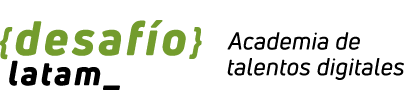

##<strong><font color="green">Ejercicio: calidad de vinos</font></strong>

Como siempre, cargamos las bibliotecas y la data necesaria.

In [13]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
print(plt.style.available)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize']=(10, 6)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [14]:
df = pd.read_csv('winequality.csv').drop(columns='Unnamed: 0')

In [15]:
df.shape

(6497, 12)

In [17]:
df.columns

Index(['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar',
       'chlorides', 'free.sulfur.dioxide', 'total.sulfur.dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

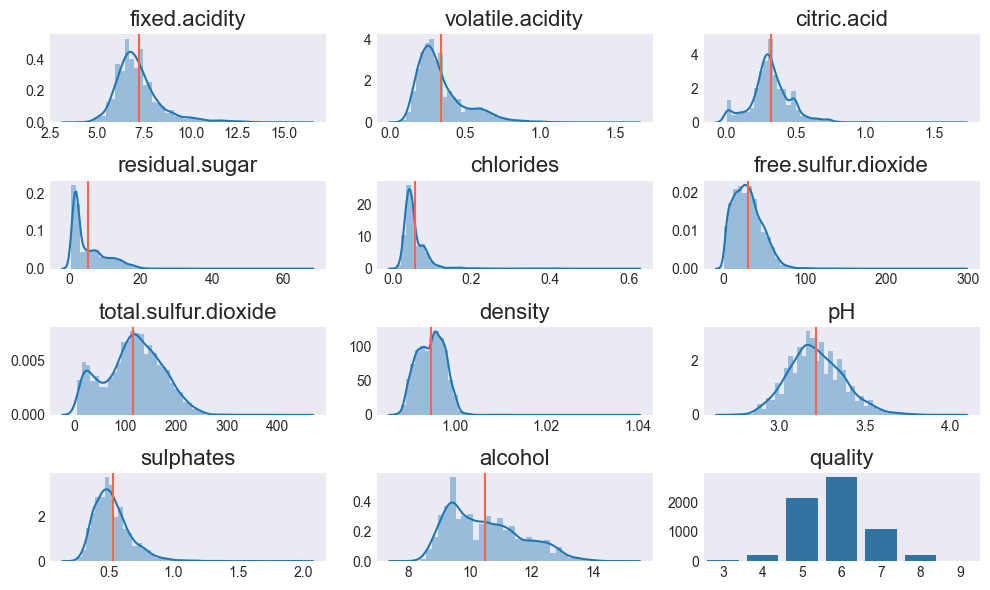

In [16]:
rows = 4; cols = int(df.shape[1] / rows)
for index, colname in enumerate(df.columns):
    serie = df[colname]
    plt.subplot(rows, cols, index + 1)
    if colname == 'quality':
        sns.countplot(x=serie)
    else:
        sns.distplot(serie)
        plt.axvline(np.mean(serie), color='tomato')
    plt.title(colname, fontsize=16)
    plt.xlabel('');plt.ylabel('');plt.tight_layout()

In [19]:
df['quality_bin'] = np.where(df['quality'] > np.mean(df['quality']), 1, 0)
df['quality_bin'].value_counts('%').round(3)

quality_bin
1    0.633
0    0.367
Name: proportion, dtype: float64

In [9]:
# Generamos las muestras de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'fixed.acidity':'alcohol'], df['quality_bin'], random_state=11238, test_size=.33)

'''
Se definen dos pipelines, uno para el clasificador KNN (wine_knn) y otro para
el Árbol de Decisión (wine_tree). Cada pipeline consta de dos pasos: primero,
se aplica la transformación de escala estándar (StandardScaler) a los datos,
y luego se aplica el modelo correspondiente (KNeighborsClassifier o
DecisionTreeClassifier).

Un pipeline (también conocido como flujo de trabajo) en el contexto del
aprendizaje automático se refiere a una secuencia de pasos encadenados que
se ejecutan de manera secuencial para procesar y transformar datos, así como
para construir y evaluar modelos de manera más eficiente y organizada. Los
pipelines son una práctica común en el preprocesamiento y modelado de datos,
ya que ayudan a automatizar y sistematizar tareas repetitivas y a garantizar
que se sigan los mismos pasos en múltiples experimentos.
'''
wine_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

wine_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', DecisionTreeClassifier())
])


In [20]:
'''Cada pipeline se entrena utilizando los datos de entrenamiento
(X_train, y_train), y luego se realizan predicciones en los datos de prueba
(X_test) para calcular el F1-score para cada modelo.
'''

wine_knn.fit(X_train, y_train)
y_hat = wine_knn.predict(X_test)
f1_knn = f1_score(y_test, y_hat)

wine_tree.fit(X_train, y_train)
y_hat = wine_tree.predict(X_test)
f1_tree = f1_score(y_test, y_hat)

print(f'El F1 Score de KNN es: {f1_knn:.3f}')
print(f'El F1 Score del decision tree es: {f1_tree:.3f}')

El F1 Score de KNN es: 0.808
El F1 Score del decision tree es: 0.815


In [11]:
'''
Se define una cuadrícula de hiperparámetros (params) que serán explorados
mediante búsqueda exhaustiva (GridSearchCV) en el modelo del Árbol de Decisión.
Los hiperparámetros incluyen min_samples_split, criterion, max_depth y
min_samples_leaf. La búsqueda  se realiza utilizando validación cruzada
con 5 pliegues (cv=5).
'''
params = {'min_samples_split': np.linspace(0.1, 1.0, 5),
          'criterion': ['gini', 'entropy'],
          'max_depth': np.arange(1, 15),
          'min_samples_leaf': np.linspace(0.1, 0.5, 5)
          }

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y su puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Mejores hiperparámetros:", best_params)
print("Puntaje del modelo con los mejores hiperparámetros:", best_score)

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}
Puntaje del modelo con los mejores hiperparámetros: 0.7368990590812516


In [12]:
'''
Se imprime un informe de clasificación utilizando classification_report, que
muestra varias métricas de evaluación del modelo en los datos de prueba, como
precisión, recall, F1-score, entre otros
'''
y_hat = grid_search.predict(X_test)
report_ = classification_report(y_test, y_hat)
print(report_)

              precision    recall  f1-score   support

           0       0.64      0.65      0.64       815
           1       0.78      0.77      0.78      1330

    accuracy                           0.73      2145
   macro avg       0.71      0.71      0.71      2145
weighted avg       0.73      0.73      0.73      2145

